In [3]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

print(torch.cuda.is_available())
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
device = torch.device("mps")

batch_size_train = 64
batch_size_test = 1000
epochs = 5
train = True

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "files/",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "files/",
        train=False,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=batch_size_test,
    shuffle=True,
)

False
True
True


1.3%

100.0%


Extracting files/MNIST/raw/train-images-idx3-ubyte.gz to files/MNIST/raw



100.0%


Extracting files/MNIST/raw/train-labels-idx1-ubyte.gz to files/MNIST/raw



2.0%

100.0%


Extracting files/MNIST/raw/t10k-images-idx3-ubyte.gz to files/MNIST/raw



100.0%

Extracting files/MNIST/raw/t10k-labels-idx1-ubyte.gz to files/MNIST/raw



In [4]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print(model)

Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [5]:
loss_values = []
test_loss_values = []

def test():
    test_loss = 0
    correct = 0

    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            prediction = model(data)
            test_loss += F.nll_loss(prediction, target, reduction="sum").item()
            pred = prediction.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_values.append(test_loss)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")


def train():
    for n in range(epochs):
        model.train()
        for batch, (data, target) in enumerate(train_loader):
            if not train:
                continue

            optimizer.zero_grad()
            prediction = model(data)

            loss = F.nll_loss(prediction, target)
            loss_values.append(loss.item())
            loss.backward()
            optimizer.step()

            if batch % 1000 == 0:
                print(f"Train Epoch: {n} [{batch * len(data)}/{len(train_loader.dataset)} ({100. * batch / len(train_loader):.0f}%)]\tLoss: {loss.item()}")
        test()

test()
train()

/var/folders/04/rkljkbxs0cj1zf8d08rzyvpc0000gn/T/ipykernel_29791/4251796113.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 2.2979, Accuracy: 1046/10000 (10%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.286346912384033

Test set: Average loss: 0.2026, Accuracy: 9375/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.5595353245735168

Test set: Average loss: 0.1292, Accuracy: 9599/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.2988665699958801

Test set: Average loss: 0.0957, Accuracy: 9694/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.16298305988311768

Test set: Average loss: 0.0799, Accuracy: 9764/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.1935826689004898

Test set: Average loss: 0.0736, Accuracy: 9778/10000 (98%)



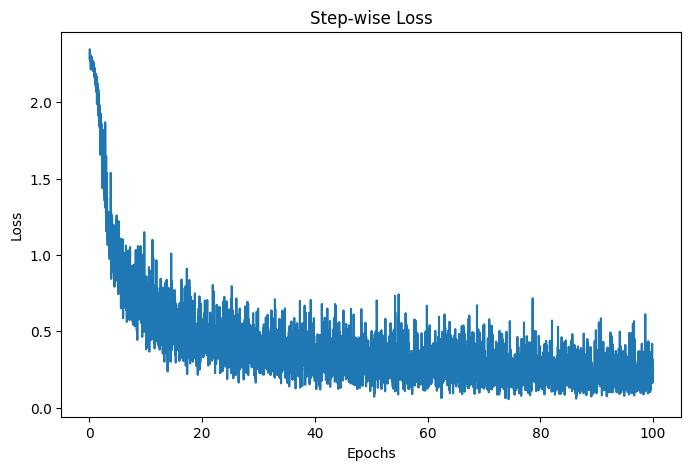

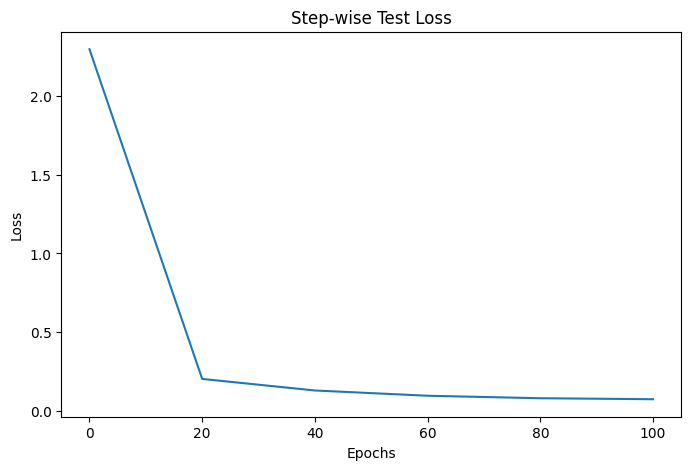

In [6]:
step = np.linspace(0, 100, len(loss_values))
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

step = np.linspace(0, 100, len(test_loss_values))
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(test_loss_values))
plt.title("Step-wise Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()